Цель исследования - персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.
Для проработки цели необходимо решить следующие задачи:
* построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца;
* выделить сегменты покупателей и разработать для них персонализированные предложения.


План работ:

1. Предобработка данных
1.1. Подгрузить данные (возможно, объединить их в единый фрейм)
1.2. Посмотреть на пропуски в разных столбцах, и если таковых немного удалить
1.3. В оставшихся пропусках попробовать заполнить логически
1.4. Удалить явные дубликаты
1.5. Преобразовать типы данных
1.6. Обработать категориальные столбцы
1.7. Посмотреть на неявные дубликаты


2. Провести анализ данных
2.1. Построить графики признаков и посмотреть на распределения
2.2. Обработать выбросы
2.3. Возможно, какие-то признаки нужно будет категоризировать (если ненормальное распределение)
2.4. Рассмотреть на взаимосвзь между признаками друг с другом и между признаками и целевой переменной


3. Построить модели
3.1. сформировать пайплайн для моделей классификации (упадет / не упадет активность клиента)
3.2. выбрать лучшую модель, проанализировать признаки (возможно, попытаться интерпретировать)


4. Решение основной задачи
4.1. Сегментировать клиентов
4.2. Предложить что-то для увеличения активности по сегментам

5. Сделать итоговые выводы

## Загрузка данных

In [1]:
!pip install phik -q # -q убирает необязательные выводы в командах Linux
!pip install shap
!pip install -Uq matplotlib

In [2]:
import pandas as pd
import numpy as np
from math import sqrt
import datetime as dt
import seaborn as sns

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

import scipy.stats as st
from scipy.stats import binom, norm, shapiro

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import shap

In [4]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',')

##  Предобработка данных

###  market_file

In [5]:
market_file.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [6]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

<div class="alert alert-info"> Аномалий не отмечено: пропусков нет, типы столбцов сочетаются с одержанием <div>

<div class="alert alert-info"> Рассмотрим категориальные признаки 
Для начала приведеми их все к нижнему регистру и спец символы поудалаяем <div>

In [7]:
cols = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
for i in cols:
    market_file[i] = market_file[i].str.lower()
    #market_file[i] = market_file[i].str.replace('_', '')
    market_file[i] = market_file[i].str.replace('"', '')
    market_file[i] = market_file[i].str.replace(' - ', '-')
    #market_file[i] = market_file[i].str.replace(' ', '')
    market_file[i] = market_file[i].str.strip()

In [8]:
for i in cols:
    print(market_file[i].unique())

['снизилась' 'прежний уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['товары для детей' 'домашний текстиль' 'косметика и аксесуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']


In [9]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].str.replace('стандартт','стандарт')
market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

###  market_money

In [10]:
market_money.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [11]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [12]:
print(market_money['Период'].unique())

['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


###  market_time

In [13]:
market_time.head()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [14]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


<div class="alert alert-info"> Аномалий не отмечено: пропусков нет, типы столбцов сочетаются с одержанием <div>

In [15]:
print(market_time['Период'].unique())

['текущий_месяц' 'предыдцщий_месяц']


In [16]:
market_time['Период'] = market_time['Период'].str.replace('предыдцщий_месяц','предыдущий_месяц')
market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

###  money

In [17]:
money.head()

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

In [18]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


<div class="alert alert-info"> Аномалий не отмечено: пропусков нет, типы столбцов сочетаются с одержанием <div>

In [19]:
len(market_file)

1300

In [20]:
market_file = market_file.drop_duplicates().reset_index(drop = True)
len(market_file)

1300

In [21]:
len(market_money)

3900

In [22]:
market_money = market_money.drop_duplicates().reset_index(drop = True)
len(market_money)

3900

In [23]:
len(market_time)

2600

In [24]:
market_time = market_time.drop_duplicates().reset_index(drop = True)
len(market_time)

2600

In [25]:
len(money)

1300

In [26]:
money = money.drop_duplicates().reset_index(drop = True)
len(money)

1300

По итогам предобработки данных:
- колонки соовтествуют содержимому
- пропусков нет
- дубликатов нет
- неявные дубликаты были устранены

## Исследовательский анализ данных

<div class="alert alert-info"> Рассмотрим количественные признаки <div>

###  market_file

In [27]:
market_file.describe()

id  Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
count    1300.000000         1300.000000           1300.000000   1300.000000   
mean   215997.500000            4.253769              4.011538    601.898462   
std       375.421985            1.014814              0.696868    249.856289   
min    215348.000000            0.900000              3.000000    110.000000   
25%    215672.750000            3.700000              4.000000    405.500000   
50%    215997.500000            4.200000              4.000000    606.000000   
75%    216322.250000            4.900000              4.000000    806.000000   
max    216647.000000            6.600000              5.000000   1079.000000   

       Акционные_покупки  Средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.000000                              1.00000   
25%             0.170000                              2.00000   
50%             0.240000                              3.00000   
75%             0.300000                              4.00000   
max             0.990000                              6.00000   

       Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
count                         1300.000000     1300.000000       1300.000000  
mean                             2.840000        4.185385          8.176923  
std                              1.971451        1.955298          3.978126  
min                              0.000000        0.000000          1.000000  
25%                              1.000000        3.000000          5.000000  
50%                              3.000000        4.000000          8.000000  
75%                              4.000000        6.000000         11.000000  
max                             10.000000        9.000000         20.000000

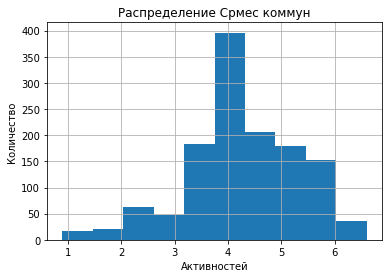

In [28]:
market_file['Маркет_актив_6_мес'].hist(bins=10)
plt.title('Распределение Срмес коммун')
plt.xlabel('Активностей')
plt.ylabel('Количество')
plt.show()

<Axes: >

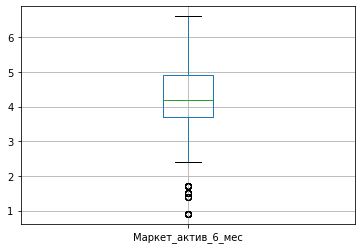

In [29]:
market_file.boxplot(column=['Маркет_актив_6_мес'])

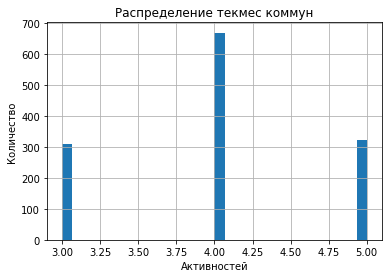

In [30]:
market_file['Маркет_актив_тек_мес'].hist(bins=30)
plt.title('Распределение текмес коммун')
plt.xlabel('Активностей')
plt.ylabel('Количество')
plt.show()

<Axes: >

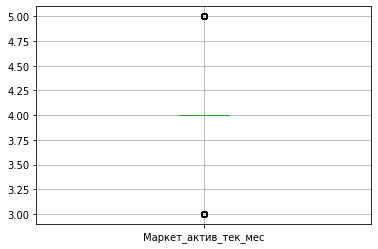

In [31]:
market_file.boxplot(column=['Маркет_актив_тек_мес'])

<div class="alert alert-info"> распределение носитя ярковыраженный категориальный характер, и в будущем предстоит преобьразованию в категории: низкое, среднее, высокое<div>

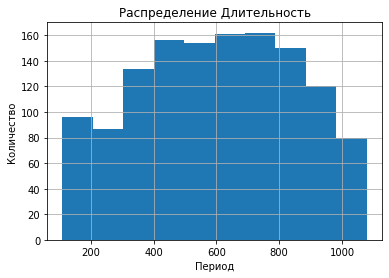

In [32]:
market_file['Длительность'].hist(bins=10)
plt.title('Распределение Длительность')
plt.xlabel('Период')
plt.ylabel('Количество')
plt.show()

<div class="alert alert-info"> распределение носит равномерный характер<div>

<Axes: >

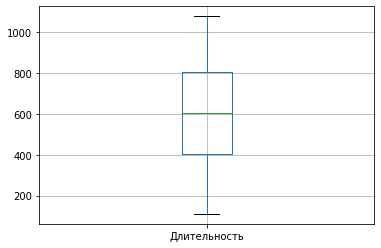

In [33]:
market_file.boxplot(column=['Длительность'])

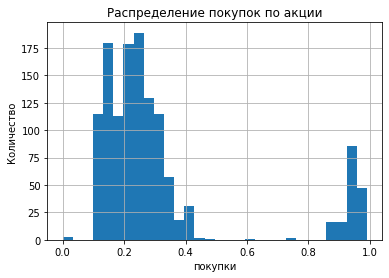

In [34]:
market_file['Акционные_покупки'].hist(bins=30)
plt.title('Распределение покупок по акции')
plt.xlabel('покупки')
plt.ylabel('Количество')
plt.show()

распределение имеет категориальный характер - можно разделить на две части: низкий (<0,5) и высокий (>=0,5)

<Axes: >

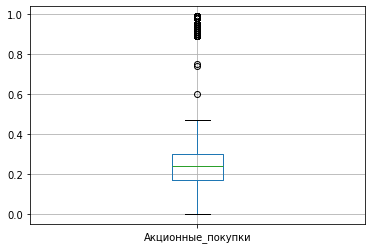

In [35]:
market_file.boxplot(column=['Акционные_покупки'])

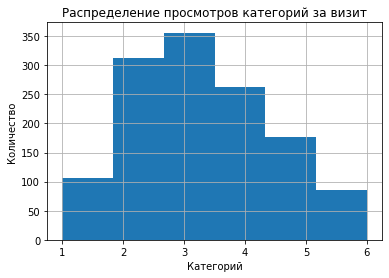

In [36]:
market_file['Средний_просмотр_категорий_за_визит'].hist(bins=6)
plt.title('Распределение просмотров категорий за визит')
plt.xlabel('Категорий')
plt.ylabel('Количество')
plt.show()

<Axes: >

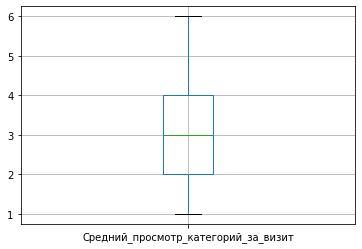

In [37]:
market_file.boxplot(column=['Средний_просмотр_категорий_за_визит'])

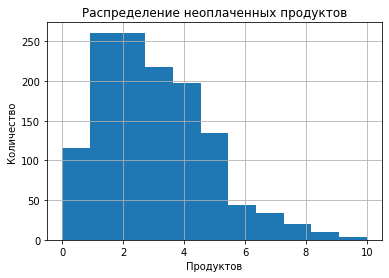

In [38]:
market_file['Неоплаченные_продукты_штук_квартал'].hist(bins=11)
plt.title('Распределение неоплаченных продуктов')
plt.xlabel('Продуктов')
plt.ylabel('Количество')
plt.show()

<Axes: >

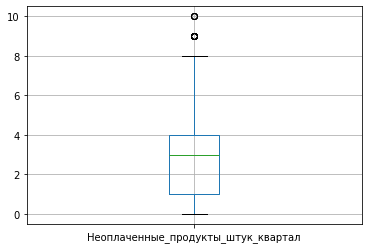

In [39]:
market_file.boxplot(column=['Неоплаченные_продукты_штук_квартал'])

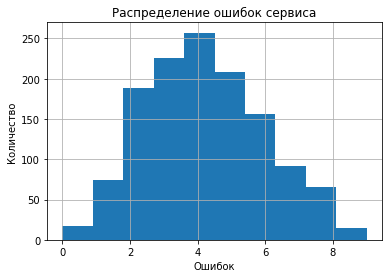

In [40]:
market_file['Ошибка_сервиса'].hist(bins=10)
plt.title('Распределение ошибок сервиса')
plt.xlabel('Ошибок')
plt.ylabel('Количество')
plt.show()

<Axes: >

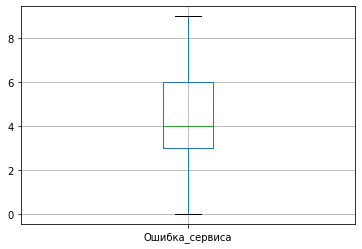

In [41]:
market_file.boxplot(column=['Ошибка_сервиса'])

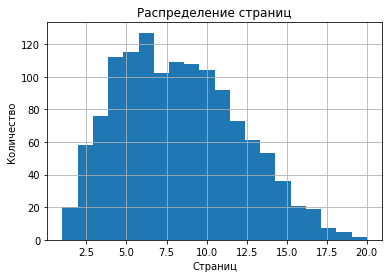

In [42]:
market_file['Страниц_за_визит'].hist(bins=20)
plt.title('Распределение страниц')
plt.xlabel('Страниц')
plt.ylabel('Количество')
plt.show()

<Axes: >

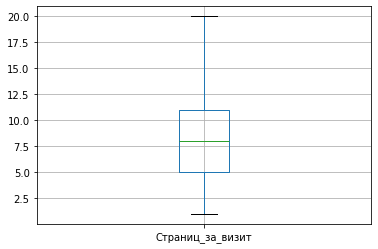

In [43]:
market_file.boxplot(column=['Страниц_за_визит'])

In [44]:
num_cols = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 
            'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']
res = pd.DataFrame(columns=['колонка', 'Результат'])
n=0
for i in num_cols:
    stat, p_val = shapiro(market_file[i])
    if p_val < 0.5: res.loc[n] = [i, 'не нормальное']
    else: res.loc[n] = [i, 'нормальное']
    n += 1
res

колонка      Результат
0                   Маркет_актив_6_мес  не нормальное
1                 Маркет_актив_тек_мес  не нормальное
2                         Длительность  не нормальное
3                    Акционные_покупки  не нормальное
4  Средний_просмотр_категорий_за_визит  не нормальное
5   Неоплаченные_продукты_штук_квартал  не нормальное
6                       Ошибка_сервиса  не нормальное
7                     Страниц_за_визит  не нормальное

<div class="alert alert-info"> Ни один из количественных признаков не имеет нормального распределения. Хотя Ошибка сервиса очень похожа на нормальное распределение. Выбросов не наблюдается (Неоплаченные_продукты_штук_квартал - я бы не считал выбросами) <div>

<div class="alert alert-info"> Рассмотрим категориальные признаки <div>

In [45]:
market_file.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 снизилась     премиум                 да   
1  215349                 снизилась     премиум                 да   
2  215350                 снизилась    стандарт                нет   
3  215351                 снизилась    стандарт                 да   
4  215352                 снизилась    стандарт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     товары для детей                                    6   
1     товары для детей                                    4   
2    домашний текстиль                                    5   
3     товары для детей                                    5   
4     товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

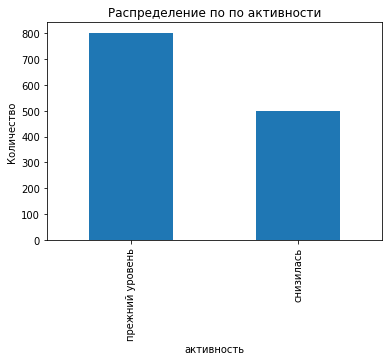

In [46]:
ax = market_file['Покупательская активность'].value_counts().plot.bar()
plt.title('Распределение по по активности')
plt.xlabel('активность')
plt.ylabel('Количество')
plt.show()

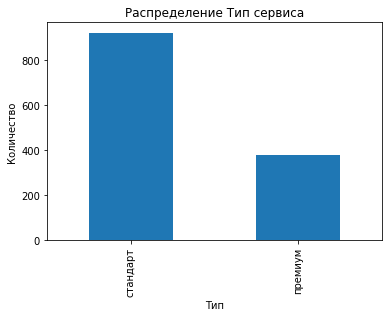

In [47]:
ax = market_file['Тип сервиса'].value_counts().plot.bar()
plt.title('Распределение Тип сервиса')
plt.xlabel('Тип')
plt.ylabel('Количество')
plt.show()

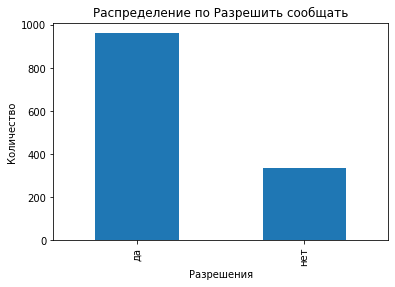

In [48]:
ax = market_file['Разрешить сообщать'].value_counts().plot.bar()
plt.title('Распределение по Разрешить сообщать')
plt.xlabel('Разрешения')
plt.ylabel('Количество')
plt.show()

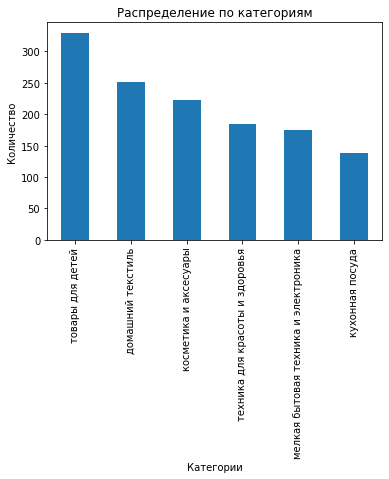

In [49]:
ax = market_file['Популярная_категория'].value_counts().plot.bar()
plt.title('Распределение по категориям')
plt.xlabel('Категории')
plt.ylabel('Количество')
plt.show()

По итогам предварительного исследовательского анализа зафиксируем:
- количественные признаки не имеют нормальное распределение
- признаки: Маркет_актив_тек_мес и Акционные_покупки имеют категориальное распределение

###  market_money

In [50]:
market_money.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [51]:
market_money.describe()

id        Выручка
count    3900.000000    3900.000000
mean   215997.500000    5025.696051
std       375.325686    1777.704104
min    215348.000000       0.000000
25%    215672.750000    4590.150000
50%    215997.500000    4957.500000
75%    216322.250000    5363.000000
max    216647.000000  106862.200000

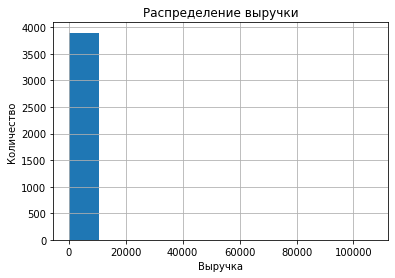

In [52]:
market_money['Выручка'].hist(bins=10)
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.ylabel('Количество')
plt.show()

<div class="alert alert-info"> обнаружены выбросы

In [53]:
market_money[market_money['Выручка'] > 100000]

id         Период   Выручка
98  215380  текущий_месяц  106862.2

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'>Действительно явный выброс.
Можно удалить, а можно и заполнить, например значением предыдущего месяца.</font>

In [54]:
market_money[market_money['id'] == 215380]

id               Период   Выручка
96  215380  препредыдущий_месяц    5051.0
97  215380     предыдущий_месяц    6077.0
98  215380        текущий_месяц  106862.2

In [55]:
a = market_money.loc[(market_money['id'] == 215380)&(market_money['Период'] == 'предыдущий_месяц'), 'Выручка'].reset_index(drop=True)
#a[0]
market_money.loc[(market_money['id'] == 215380)&(market_money['Период'] == 'текущий_месяц'), 'Выручка'] = a[0]
market_money[market_money['id'] == 215380]

id               Период  Выручка
96  215380  препредыдущий_месяц   5051.0
97  215380     предыдущий_месяц   6077.0
98  215380        текущий_месяц   6077.0

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'> 👍</font>

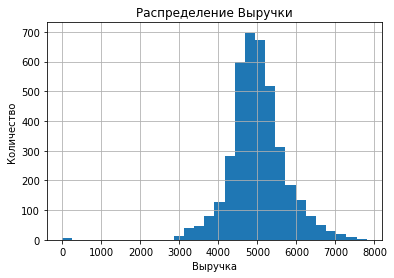

In [56]:

market_money['Выручка'].hist(bins=30)
plt.title('Распределение Выручки')
plt.xlabel('Выручка')
plt.ylabel('Количество')
plt.show()

In [57]:
market_money[market_money['Выручка'] < 1000]

id               Период  Выручка
0   215348  препредыдущий_месяц      0.0
2   215348     предыдущий_месяц      0.0
28  215357  препредыдущий_месяц      0.0
29  215357     предыдущий_месяц      0.0
34  215359     предыдущий_месяц      0.0
35  215359  препредыдущий_месяц      0.0

<div class="alert alert-info"> Оставим клиентов с ненулевой выручкой  <div>

In [58]:
null_clients = market_money[market_money['Выручка'] == 0]
null_clients = null_clients['id']
null_clients

0     215348
2     215348
28    215357
29    215357
34    215359
35    215359
Name: id, dtype: int64

In [59]:
market_money = market_money[~market_money['id'].isin(null_clients)]
market_file = market_file[~market_file['id'].isin(null_clients)]
market_time = market_time[~market_time['id'].isin(null_clients)]

<div class="alert alert-info"> Объединим таблицы  <div>

In [60]:
market_file.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
1  215349                 снизилась     премиум                 да   
2  215350                 снизилась    стандарт                нет   
3  215351                 снизилась    стандарт                 да   
4  215352                 снизилась    стандарт                нет   
5  215353                 снизилась    стандарт                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   
5                 3.3                     4           762               0.26   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
1     товары для детей                                    4   
2    домашний текстиль                                    5   
3     товары для детей                                    5   
4     товары для детей                                    3   
5    домашний текстиль                                    4   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2  
5                                   1               1                 4

In [61]:
market_file = market_file.set_index('id')
market_file.head()

Покупательская активность Тип сервиса Разрешить сообщать  \
id                                                                
215349                 снизилась     премиум                 да   
215350                 снизилась    стандарт                нет   
215351                 снизилась    стандарт                 да   
215352                 снизилась    стандарт                нет   
215353                 снизилась    стандарт                 да   

        Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   
215353                 3.3                     4           762   

        Акционные_покупки Популярная_категория  \
id                                               
215349               0.75     товары для детей   
215350               0.14    домашний текстиль   
215351               0.99     товары для детей   
215352               0.94     товары для детей   
215353               0.26    домашний текстиль   

        Средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   
215352                                    3   
215353                                    4   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
id                                                                            
215349                                   4               2                 5  
215350                                   2               1                 5  
215351                                   0               6                 4  
215352                                   2               3                 2  
215353                                   1               1                 4

In [62]:
market_money.head()

id               Период  Выручка
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6
5  215349     предыдущий_месяц   5216.0
6  215350  препредыдущий_месяц   4826.0
7  215350        текущий_месяц   5058.4

In [63]:
market_money[market_money['id']==215380]

id               Период  Выручка
96  215380  препредыдущий_месяц   5051.0
97  215380     предыдущий_месяц   6077.0
98  215380        текущий_месяц   6077.0

In [64]:
market_money = market_money.pivot_table(index=['id'], columns='Период', values='Выручка', aggfunc='sum')
market_money.columns = ['Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц']
market_money.head()

Выручка_предыдущий_месяц  Выручка_препредыдущий_месяц  \
id                                                              
215349                    5216.0                       4472.0   
215350                    5457.5                       4826.0   
215351                    6158.0                       4793.0   
215352                    5807.5                       4594.0   
215353                    4738.5                       5124.0   

        Выручка_текущий_месяц  
id                             
215349                 4971.6  
215350                 5058.4  
215351                 6610.4  
215352                 5872.5  
215353                 5388.5

In [65]:
market_money[market_money['Выручка_текущий_месяц'].isna()]

Empty DataFrame
Columns: [Выручка_предыдущий_месяц, Выручка_препредыдущий_месяц, Выручка_текущий_месяц]
Index: []

In [66]:
market_time.head()

id            Период  минут
2  215349     текущий_месяц     10
3  215349  предыдущий_месяц     12
4  215350     текущий_месяц     13
5  215350  предыдущий_месяц      8
6  215351     текущий_месяц     13

In [67]:
market_time = market_time.pivot_table(index=['id'], columns='Период', values='минут', aggfunc='sum')
market_time.columns = ['Время_предыдущий_месяц', 'Время_текущий_месяц']
market_time.head()

Время_предыдущий_месяц  Время_текущий_месяц
id                                                 
215349                      12                   10
215350                       8                   13
215351                      11                   13
215352                       8                   11
215353                      10                   10

In [68]:
data_full = market_file.merge(market_money, how = 'left', on = 'id')
data_full = data_full.merge(market_time, how = 'left', on = 'id')
data_full.head()

Покупательская активность Тип сервиса Разрешить сообщать  \
id                                                                
215349                 снизилась     премиум                 да   
215350                 снизилась    стандарт                нет   
215351                 снизилась    стандарт                 да   
215352                 снизилась    стандарт                нет   
215353                 снизилась    стандарт                 да   

        Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   
215353                 3.3                     4           762   

        Акционные_покупки Популярная_категория  \
id                                               
215349               0.75     товары для детей   
215350               0.14    домашний текстиль   
215351               0.99     товары для детей   
215352               0.94     товары для детей   
215353               0.26    домашний текстиль   

        Средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   
215352                                    3   
215353                                    4   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   

        Выручка_предыдущий_месяц  Выручка_препредыдущий_месяц  \
id                                                              
215349                    5216.0                       4472.0   
215350                    5457.5                       4826.0   
215351                    6158.0                       4793.0   
215352                    5807.5                       4594.0   
215353                    4738.5                       5124.0   

        Выручка_текущий_месяц  Время_предыдущий_месяц  Время_текущий_месяц  
id                                                                          
215349                 4971.6                      12                   10  
215350                 5058.4                       8                   13  
215351                 6610.4                      11                   13  
215352                 5872.5                       8                   11  
215353                 5388.5                      10                   10

<div class="alert alert-info"> Построим матрицу корреляций <div>

In [69]:
interval_cols = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',
                'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц',
                'Время_предыдущий_месяц', 'Время_текущий_месяц']
cat_cols = list(set(data_full.columns)-set(interval_cols))


phik_overview = data_full.phik_matrix(interval_cols=interval_cols)
print(phik_overview.shape)

(17, 17)


In [70]:
cat_cols

['Разрешить сообщать',
 'Страниц_за_визит',
 'Ошибка_сервиса',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Тип сервиса',
 'Покупательская активность',
 'Популярная_категория']

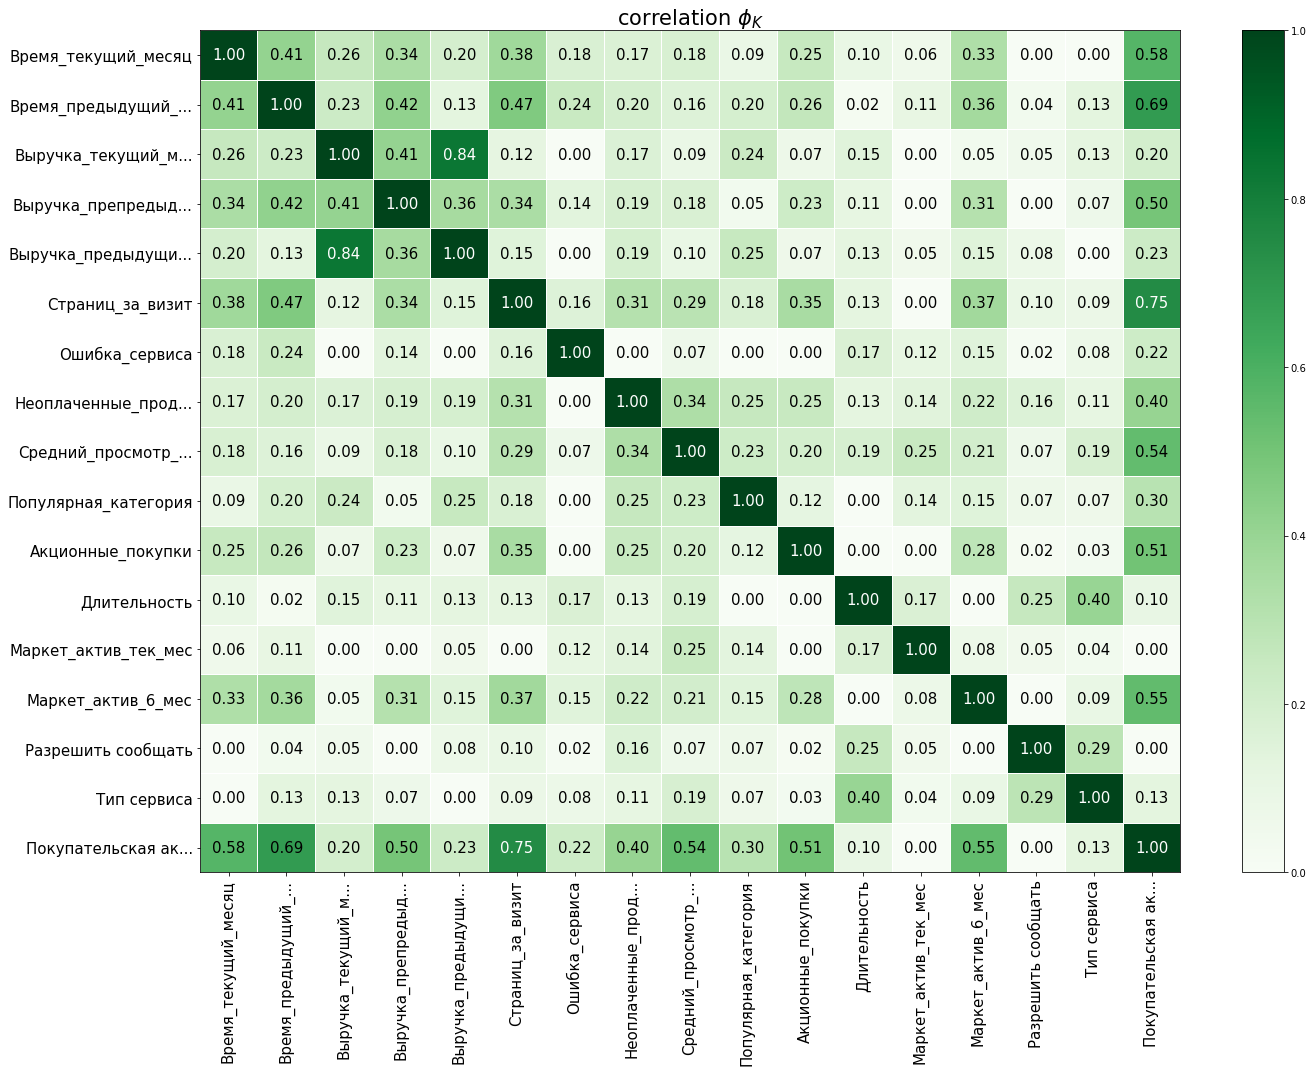

In [71]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

<div class="alert alert-info"> Сильная зависимость прослеживается между факторами: Выручка за тек месяц и Выручка за предыдущий месяц = 0,84 (> 0,75). Учитывая, что выручка за предыдущий месяц имеет большую корреляцию с целевым признаком (0,23 vs 0,20) - можно удалить признак Выручка за текущий месяц <div>

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable Покупательская активность for analysis 1. Dropping this column
  warnings.warn(


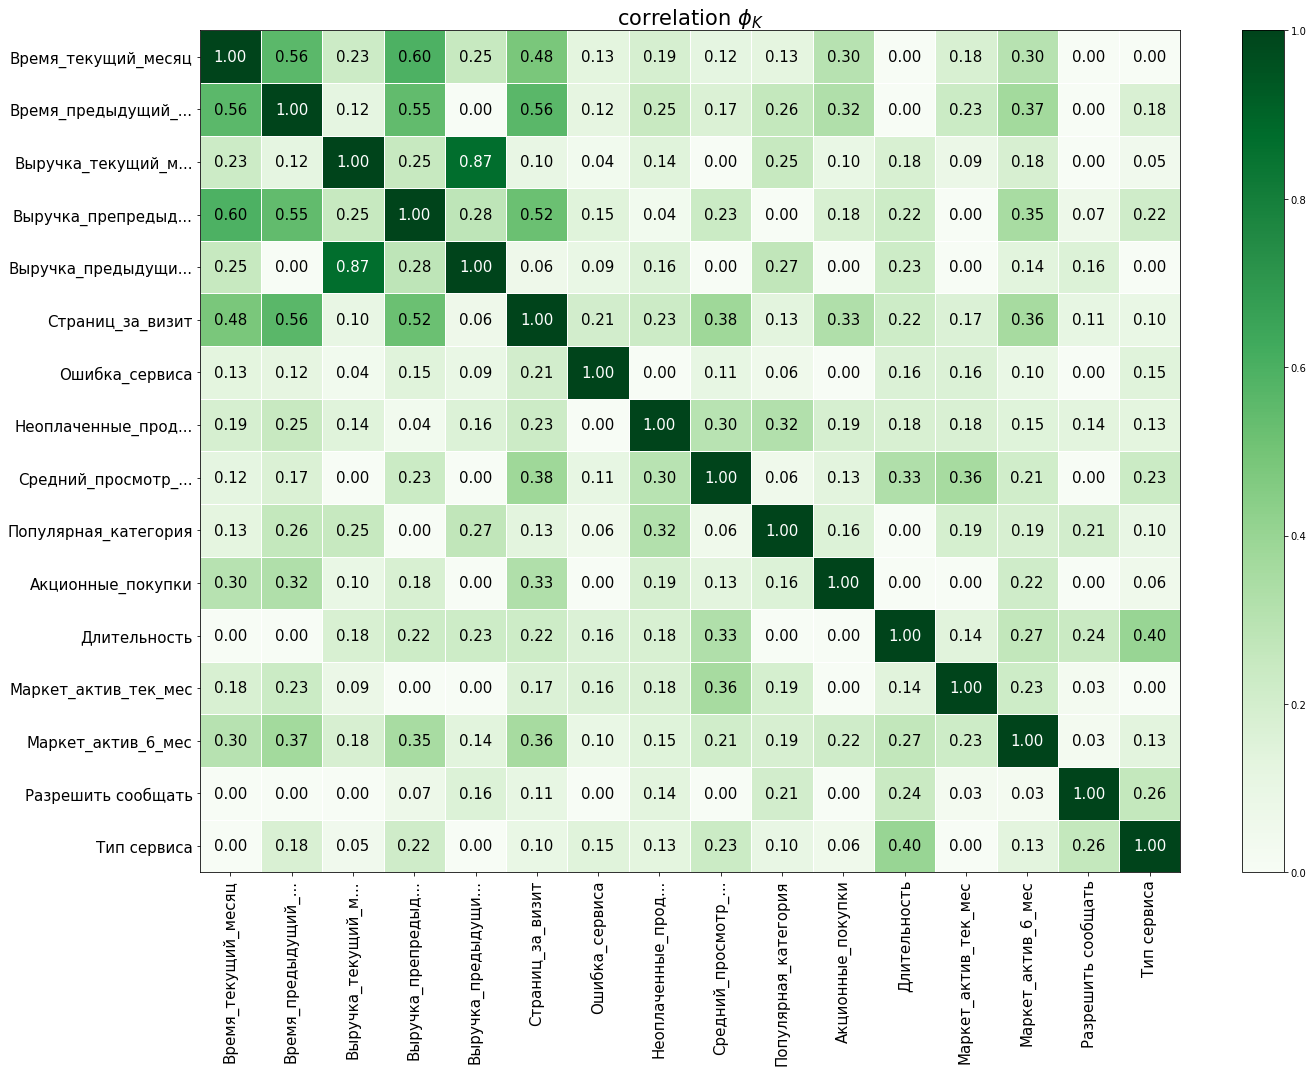

In [72]:
data_full_low = data_full[data_full['Покупательская активность']=='снизилась']
phik_overview = data_full_low.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable Покупательская активность for analysis 1. Dropping this column
  warnings.warn(


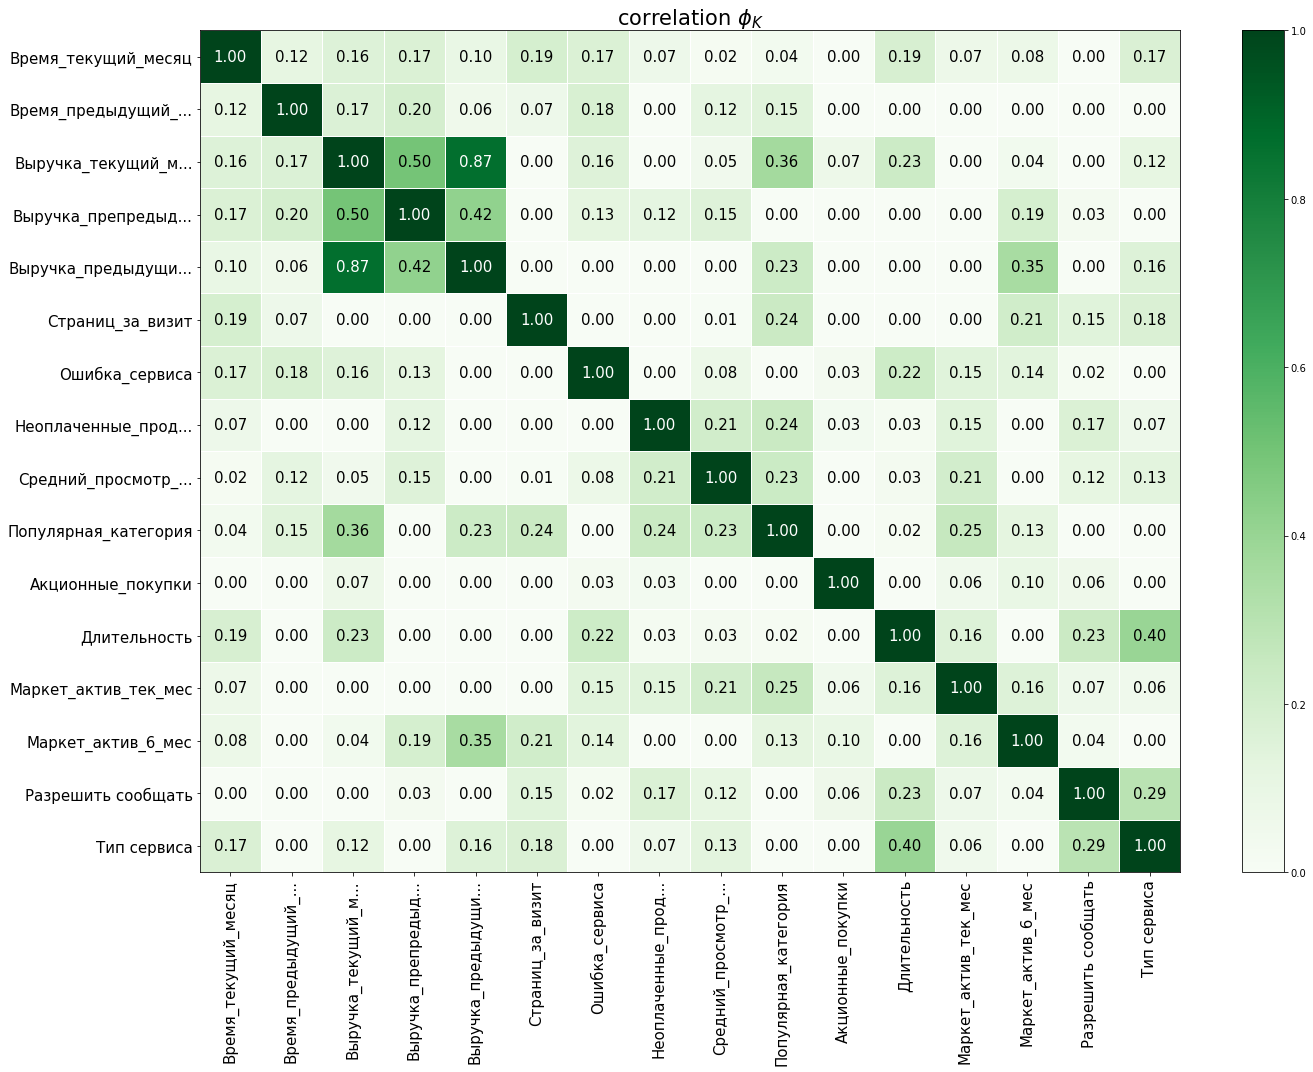

In [73]:
data_full_norm = data_full[data_full['Покупательская активность']=='прежний уровень']
phik_overview = data_full_norm.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

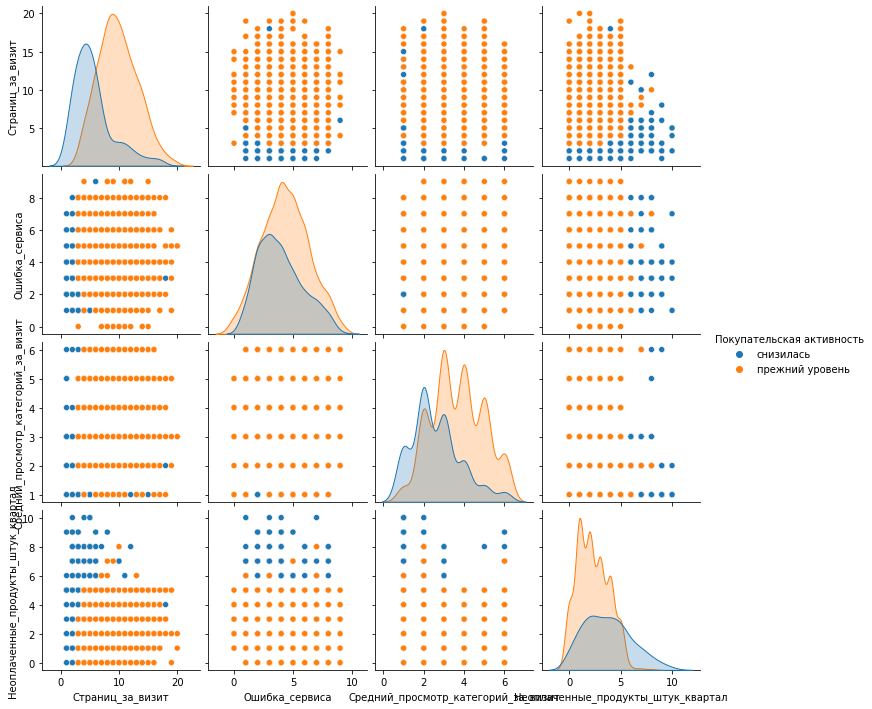

In [74]:
sns.pairplot(data_full[cat_cols], hue = 'Покупательская активность')

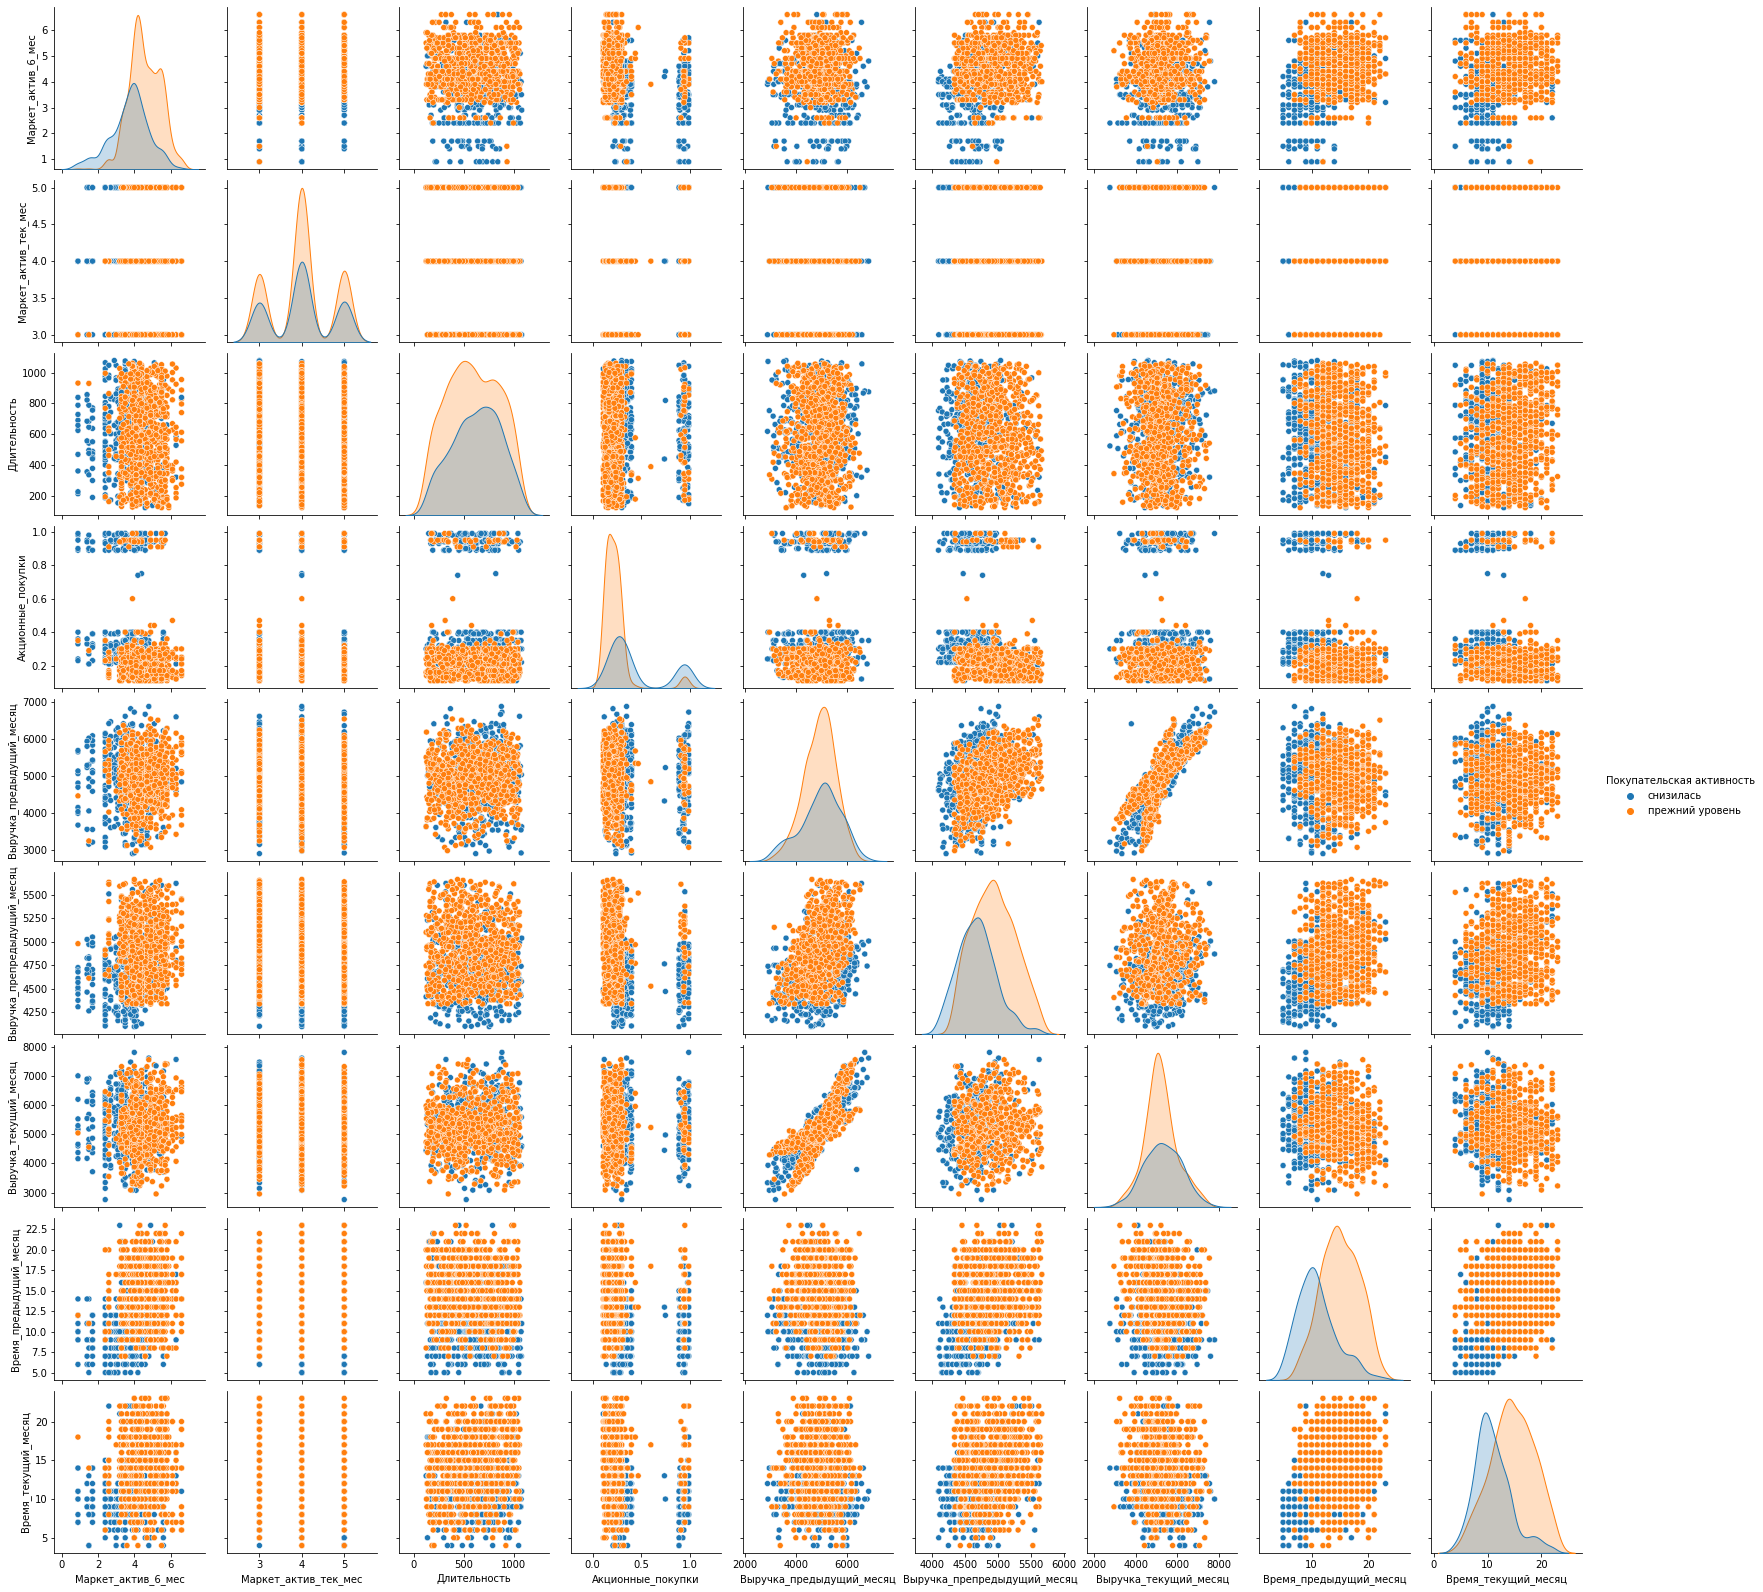

In [75]:
#int_cols = interval_cols+['Покупательская активность']
#int_cols
sns.pairplot(data_full[interval_cols+['Покупательская активность']], hue = 'Покупательская активность')

In [76]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1297 non-null   object 
 1   Тип сервиса                          1297 non-null   object 
 2   Разрешить сообщать                   1297 non-null   object 
 3   Маркет_актив_6_мес                   1297 non-null   float64
 4   Маркет_актив_тек_мес                 1297 non-null   int64  
 5   Длительность                         1297 non-null   int64  
 6   Акционные_покупки                    1297 non-null   float64
 7   Популярная_категория                 1297 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 10  Ошибка_сервиса                       1297 non-null   int64  
 11  Страниц_за_визит       

## Построение модели

<div class="alert alert-info"> Для начала осуществим все преобразования, на основе выводов, по которым я пришел выше <div>
    
    - уберем столбец Выручка за текущий месяц
    - категоризуем признак Акционные_покупки
    - категоризуем признак Маркет_актив_тек_мес

In [77]:
data_full = data_full.drop('Выручка_текущий_месяц',axis=1)
data_full.head()

Покупательская активность Тип сервиса Разрешить сообщать  \
id                                                                
215349                 снизилась     премиум                 да   
215350                 снизилась    стандарт                нет   
215351                 снизилась    стандарт                 да   
215352                 снизилась    стандарт                нет   
215353                 снизилась    стандарт                 да   

        Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   
215353                 3.3                     4           762   

        Акционные_покупки Популярная_категория  \
id                                               
215349               0.75     товары для детей   
215350               0.14    домашний текстиль   
215351               0.99     товары для детей   
215352               0.94     товары для детей   
215353               0.26    домашний текстиль   

        Средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   
215352                                    3   
215353                                    4   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   

        Выручка_предыдущий_месяц  Выручка_препредыдущий_месяц  \
id                                                              
215349                    5216.0                       4472.0   
215350                    5457.5                       4826.0   
215351                    6158.0                       4793.0   
215352                    5807.5                       4594.0   
215353                    4738.5                       5124.0   

        Время_предыдущий_месяц  Время_текущий_месяц  
id                                                   
215349                      12                   10  
215350                       8                   13  
215351                      11                   13  
215352                       8                   11  
215353                      10                   10

In [78]:
data_full['Акционные_покупки'] = data_full['Акционные_покупки'].apply(lambda x : 'акц_пок_низк' if x<0.5 else 'акц_пок_высок')
data_full['Акционные_покупки'] 

id
215349    акц_пок_высок
215350     акц_пок_низк
215351    акц_пок_высок
215352    акц_пок_высок
215353     акц_пок_низк
              ...      
216643     акц_пок_низк
216644     акц_пок_низк
216645     акц_пок_низк
216646     акц_пок_низк
216647    акц_пок_высок
Name: Акционные_покупки, Length: 1297, dtype: object

In [79]:
data_full['Маркет_актив_тек_мес'] = data_full['Маркет_актив_тек_мес'].apply(lambda x : 'маркт_акт_низк' if x<=3.5 else ('маркт_акт_средн' if x<=4.5 else 'маркт_акт_высок'))
data_full['Маркет_актив_тек_мес'] 

id
215349    маркт_акт_средн
215350     маркт_акт_низк
215351    маркт_акт_высок
215352     маркт_акт_низк
215353    маркт_акт_средн
               ...       
216643     маркт_акт_низк
216644    маркт_акт_средн
216645     маркт_акт_низк
216646    маркт_акт_высок
216647    маркт_акт_высок
Name: Маркет_актив_тек_мес, Length: 1297, dtype: object

In [80]:
data_full.loc[data_full['Разрешить сообщать']=='да', ['Разрешить сообщать']] = 'Разрешить сообщать_да'
data_full.loc[data_full['Разрешить сообщать']=='нет', ['Разрешить сообщать']] = 'Разрешить сообщать_нет'
data_full['Разрешить сообщать']

id
215349     Разрешить сообщать_да
215350    Разрешить сообщать_нет
215351     Разрешить сообщать_да
215352    Разрешить сообщать_нет
215353     Разрешить сообщать_да
                   ...          
216643     Разрешить сообщать_да
216644    Разрешить сообщать_нет
216645     Разрешить сообщать_да
216646     Разрешить сообщать_да
216647     Разрешить сообщать_да
Name: Разрешить сообщать, Length: 1297, dtype: object

In [81]:
data_full.head()

Покупательская активность Тип сервиса      Разрешить сообщать  \
id                                                                     
215349                 снизилась     премиум   Разрешить сообщать_да   
215350                 снизилась    стандарт  Разрешить сообщать_нет   
215351                 снизилась    стандарт   Разрешить сообщать_да   
215352                 снизилась    стандарт  Разрешить сообщать_нет   
215353                 снизилась    стандарт   Разрешить сообщать_да   

        Маркет_актив_6_мес Маркет_актив_тек_мес  Длительность  \
id                                                              
215349                 4.4      маркт_акт_средн           819   
215350                 4.9       маркт_акт_низк           539   
215351                 3.2      маркт_акт_высок           896   
215352                 5.1       маркт_акт_низк          1064   
215353                 3.3      маркт_акт_средн           762   

       Акционные_покупки Популярная_категория  \
id                                              
215349     акц_пок_высок     товары для детей   
215350      акц_пок_низк    домашний текстиль   
215351     акц_пок_высок     товары для детей   
215352     акц_пок_высок     товары для детей   
215353      акц_пок_низк    домашний текстиль   

        Средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   
215352                                    3   
215353                                    4   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   

        Выручка_предыдущий_месяц  Выручка_препредыдущий_месяц  \
id                                                              
215349                    5216.0                       4472.0   
215350                    5457.5                       4826.0   
215351                    6158.0                       4793.0   
215352                    5807.5                       4594.0   
215353                    4738.5                       5124.0   

        Время_предыдущий_месяц  Время_текущий_месяц  
id                                                   
215349                      12                   10  
215350                       8                   13  
215351                      11                   13  
215352                       8                   11  
215353                      10                   10

In [82]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = data_full.drop('Покупательская активность', axis = 1)
y = data_full['Покупательская активность']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE, stratify = y)

In [84]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

#pd.DataFrame(y_train1, y_train, columns=['LabelEncoder']) 

In [85]:
ohe_columns = ['Разрешить сообщать', 'Популярная_категория', 'Акционные_покупки', 'Маркет_актив_тек_мес']
ord_columns = ['Тип сервиса']
num_columns = ['Маркет_актив_6_мес', 'Длительность', 
               'Средний_просмотр_категорий_за_визит','Неоплаченные_продукты_штук_квартал','Ошибка_сервиса','Страниц_за_визит',
              'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц',
               'Время_предыдущий_месяц', 'Время_текущий_месяц']

In [86]:
# !!!Не смог придумать, как более изящно вытащить результирующие столбцы, чтобы потом в интерпретацуии модели их использовать

# создаём экземпляр класса OneHotEncoder для кодирования
oh_encoder = OneHotEncoder(sparse=False)

# обучаем OneHotEncoder на категориальных признаках из тренировочной выборки
oh_encoder.fit(X_train[ohe_columns])

# сохраняем в переменной encoder_col_names список названий новых столбцов
encoder_col_names = oh_encoder.get_feature_names()
end_cols = list(encoder_col_names) + list(ord_columns) + list(num_columns)
end_cols

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['x0_Разрешить сообщать_да',
 'x0_Разрешить сообщать_нет',
 'x1_домашний текстиль',
 'x1_косметика и аксесуары',
 'x1_кухонная посуда',
 'x1_мелкая бытовая техника и электроника',
 'x1_техника для красоты и здоровья',
 'x1_товары для детей',
 'x2_акц_пок_высок',
 'x2_акц_пок_низк',
 'x3_маркт_акт_высок',
 'x3_маркт_акт_низк',
 'x3_маркт_акт_средн',
 'Тип сервиса',
 'Маркет_актив_6_мес',
 'Длительность',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Ошибка_сервиса',
 'Страниц_за_визит',
 'Выручка_предыдущий_месяц',
 'Выручка_препредыдущий_месяц',
 'Время_предыдущий_месяц',
 'Время_текущий_месяц']

In [87]:
ohe_pipe=Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                 ('ohe', OneHotEncoder(sparse=False))])

In [88]:
ord_pipe=Pipeline([('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy = 'most_frequent')),
                 ('ord',  OrdinalEncoder(categories=[['стандарт', 'премиум'],], 
                handle_unknown='use_encoded_value', unknown_value=np.nan)),
                 ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

In [89]:
data_preprocessor=ColumnTransformer([('ohe',ohe_pipe,ohe_columns),
                                    ('ord',ord_pipe,ord_columns),
                                    ('num',StandardScaler(),num_columns)],
                                    remainder='passthrough')

In [90]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [91]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE,solver='liblinear',penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(kernel = 'poly', probability=True, random_state=RANDOM_STATE)],
        'models__degree': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [92]:
#pipe_final.fit(X_train, y_train)

In [93]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1)

In [94]:
grid.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(sparse=False))]),
                                                                         ['Разрешить '
                                                                          'сообщать',
                                                                          'Популярная_категория',
                                                                          'Акционные_покупки',
                                                                          'Маркет_актив_тек_мес']),
                                                                        ('ord',
                                                                         Pipeline(step...
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVC(degree=4, kernel='poly',
                                         probability=True, random_state=42)],
                          'models__degree': range(2, 10),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [95]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(grid.cv_results_)
#print(result[
#    ['rank_test_score', 'param_models', 'mean_test_score','params']
#].sort_values('rank_test_score'))
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 

rank_test_score  \
54                1   
51                2   
57                3   
60                4   
63                5   
..              ...   
2                68   
1                68   
0                68   
32               71   
29               72   

                                                       param_models  \
54  SVC(degree=4, kernel='poly', probability=True, random_state=42)   
51  SVC(degree=4, kernel='poly', probability=True, random_state=42)   
57  SVC(degree=4, kernel='poly', probability=True, random_state=42)   
60  SVC(degree=4, kernel='poly', probability=True, random_state=42)   
63  SVC(degree=4, kernel='poly', probability=True, random_state=42)   
..                                                              ...   
2                           DecisionTreeClassifier(random_state=42)   
1                           DecisionTreeClassifier(random_state=42)   
0                           DecisionTreeClassifier(random_state=42)   
32                                           KNeighborsClassifier()   
29                                           KNeighborsClassifier()   

    mean_test_score  \
54         0.908276   
51         0.907840   
57         0.905857   
60         0.900545   
63         0.897211   
..              ...   
2          0.702306   
1          0.702306   
0          0.702306   
32         0.702199   
29         0.686593   

                                                                                                                                           params  
54        {'models': SVC(degree=4, kernel='poly', probability=True, random_state=42), 'models__degree': 4, 'preprocessor__num': StandardScaler()}  
51        {'models': SVC(degree=4, kernel='poly', probability=True, random_state=42), 'models__degree': 3, 'preprocessor__num': StandardScaler()}  
57        {'models': SVC(degree=4, kernel='poly', probability=True, random_state=42), 'models__degree': 5, 'preprocessor__num': StandardScaler()}  
60        {'models': SVC(degree=4, kernel='poly', probability=True, random_state=42), 'models__degree': 6, 'preprocessor__num': StandardScaler()}  
63        {'models': SVC(degree=4, kernel='poly', probability=True, random_state=42), 'models__degree': 7, 'preprocessor__num': StandardScaler()}  
..                                                                                                                                            ...  
2      {'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 2, 'preprocessor__num': 'passthrough'}  
1     {'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 2, 'preprocessor__num': MinMaxScaler()}  
0   {'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 2, 'preprocessor__num': StandardScaler()}  
32                                               {'models': KNeighborsClassifier(), 'models__n_neighbors': 3, 'preprocessor__num': 'passthrough'}  
29                                               {'models': KNeighborsClassifier(), 'models__n_neighbors': 2, 'preprocessor__num': 'passthrough'}  

[72 rows x 4 columns]

In [96]:
result.loc[result['rank_test_score']==1]


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
54       0.103347        0.0025         0.012106        0.002175   

                                                       param_models  \
54  SVC(degree=4, kernel='poly', probability=True, random_state=42)   

   param_models__max_depth param_models__max_features param_preprocessor__num  \
54                     NaN                        NaN        StandardScaler()   

   param_models__n_neighbors param_models__C param_models__degree  \
54                       NaN             NaN                    4   

                                                                                                                                     params  \
54  {'models': SVC(degree=4, kernel='poly', probability=True, random_state=42), 'models__degree': 4, 'preprocessor__num': StandardScaler()}   

    split0_test_score  split1_test_score  split2_test_score  \
54           0.932321           0.896222           0.924324   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
54           0.903604            0.88491         0.908276          0.0176   

    rank_test_score  
54                1

In [97]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_)
y_test_pred = grid.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Разрешить сообщать',
                                                   'Популярная_категория',
                                                   'Акционные_покупки',
                                                   'Маркет_актив_тек_мес']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord'.

In [98]:
probabilities = grid.best_estimator_.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.9063151982025357


## Анализ важности признаков

In [99]:
X_test.head()

Тип сервиса     Разрешить сообщать  Маркет_актив_6_мес  \
id                                                              
216446    стандарт  Разрешить сообщать_да                 5.3   
215469     премиум  Разрешить сообщать_да                 4.1   
216301     премиум  Разрешить сообщать_да                 3.9   
215713    стандарт  Разрешить сообщать_да                 4.6   
215500    стандарт  Разрешить сообщать_да                 3.5   

       Маркет_актив_тек_мес  Длительность Акционные_покупки  \
id                                                            
216446      маркт_акт_высок           433     акц_пок_высок   
215469       маркт_акт_низк           813      акц_пок_низк   
216301      маркт_акт_высок           410      акц_пок_низк   
215713      маркт_акт_высок           293      акц_пок_низк   
215500      маркт_акт_средн           573      акц_пок_низк   

                  Популярная_категория  Средний_просмотр_категорий_за_визит  \
id                                                                            
216446  техника для красоты и здоровья                                    1   
215469               домашний текстиль                                    3   
216301           косметика и аксесуары                                    3   
215713                товары для детей                                    1   
215500           косметика и аксесуары                                    2   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
216446                                   1               0                 7   
215469                                   3               4                 5   
216301                                   1               5                14   
215713                                   3               3                 3   
215500                                   4               1                 4   

        Выручка_предыдущий_месяц  Выручка_препредыдущий_месяц  \
id                                                              
216446                    4712.0                       5160.0   
215469                    5403.5                       4889.0   
216301                    5052.5                       5348.0   
215713                    4821.0                       4872.0   
215500                    4137.0                       4278.0   

        Время_предыдущий_месяц  Время_текущий_месяц  
id                                                   
216446                      15                   20  
215469                      12                    8  
216301                      17                   13  
215713                      12                   14  
215500                      11                   12

In [100]:
x_Test = grid.best_estimator_.named_steps['preprocessor'].fit_transform(X_test)
model = grid.best_estimator_.named_steps['models']
explainer = shap.Explainer(model.predict, x_Test)
#explainer = shap.KernelExplainer(model.predict, x_Test)

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [101]:
df=pd.DataFrame(x_Test, columns=end_cols)
df.head()

x0_Разрешить сообщать_да  x0_Разрешить сообщать_нет  x1_домашний текстиль  \
0                       1.0                        0.0                   0.0   
1                       1.0                        0.0                   1.0   
2                       1.0                        0.0                   0.0   
3                       1.0                        0.0                   0.0   
4                       1.0                        0.0                   0.0   

   x1_косметика и аксесуары  x1_кухонная посуда  \
0                       0.0                 0.0   
1                       0.0                 0.0   
2                       1.0                 0.0   
3                       0.0                 0.0   
4                       1.0                 0.0   

   x1_мелкая бытовая техника и электроника  x1_техника для красоты и здоровья  \
0                                      0.0                                1.0   
1                                      0.0                                0.0   
2                                      0.0                                0.0   
3                                      0.0                                0.0   
4                                      0.0                                0.0   

   x1_товары для детей  x2_акц_пок_высок  x2_акц_пок_низк  ...  \
0                  0.0               1.0              0.0  ...   
1                  0.0               0.0              1.0  ...   
2                  0.0               0.0              1.0  ...   
3                  1.0               0.0              1.0  ...   
4                  0.0               0.0              1.0  ...   

   Маркет_актив_6_мес  Длительность  Средний_просмотр_категорий_за_визит  \
0            1.101967     -0.668987                            -1.679787   
1           -0.159087      0.895488                            -0.214201   
2           -0.369263     -0.763679                            -0.214201   
3            0.366352     -1.245373                            -1.679787   
4           -0.789614     -0.092602                            -0.946994   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
0                           -0.945559       -2.085407         -0.243291   
1                            0.072013       -0.034704         -0.739024   
2                           -0.945559        0.477971          1.491777   
3                            0.072013       -0.547380         -1.234758   
4                            0.580799       -1.572731         -0.986891   

   Выручка_предыдущий_месяц  Выручка_препредыдущий_месяц  \
0                 -0.271501                     1.093320   
1                  0.718720                     0.260254   
2                  0.216092                     1.671241   
3                 -0.115414                     0.207995   
4                 -1.094895                    -1.617989   

   Время_предыдущий_месяц  Время_текущий_месяц  
0                0.459728             1.570264  
1               -0.323900            -1.214652  
2                0.982147            -0.054270  
3               -0.323900             0.177806  
4               -0.585109            -0.286346  

[5 rows x 24 columns]

In [102]:
#explainer = shap.KernelExplainer(grid.best_estimator_.named_steps['models'], x_Train[:30])
shap_values = explainer(df)


PermutationExplainer explainer: 326it [02:51,  1.83it/s]                         


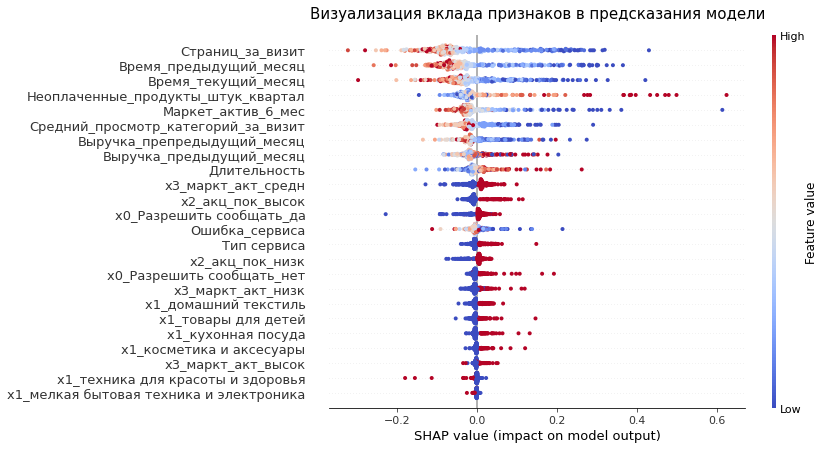

In [103]:
# визуализируем вклад признаков на диаграмме
shap.summary_plot(shap_values, df, show=False, plot_size=[12, 6], cmap='coolwarm',  max_display=30)
plt.title('Визуализация вклада признаков в предсказания модели', size=15, y=1.03)
plt.show()

Крупнейшие факторы, оказывающие влиения:
- Страниц_за_визит
- Время в предыдущем месяце
- Время в текущем месяце
- Маркетинговая активность
Высокие значения каждого из этих параметров ведет к тому, что модель присвоит уцелевой переменной признак 0

- Неоплаченные продукты
Высокие значения этого параметра ведет к тому, что модель присвоит уцелевой переменной признак 1


Интерпретировать можно следующим образом:
Чем больше активности проявляет клиент (посещает количество страниц, проводит времени в настоящем и прошлом месяцах (то есть он сохраняет активность на протяжении двух месяцев), участвует в маркетинговых акциях) - тем с большей вероятностью он продолжит это делат ьи в дальнейшем, то есть активность его не снизится

Однако, если Клиент имеет неоплаченные заказы - это сигнал к тому, что в последующем его активность упадет


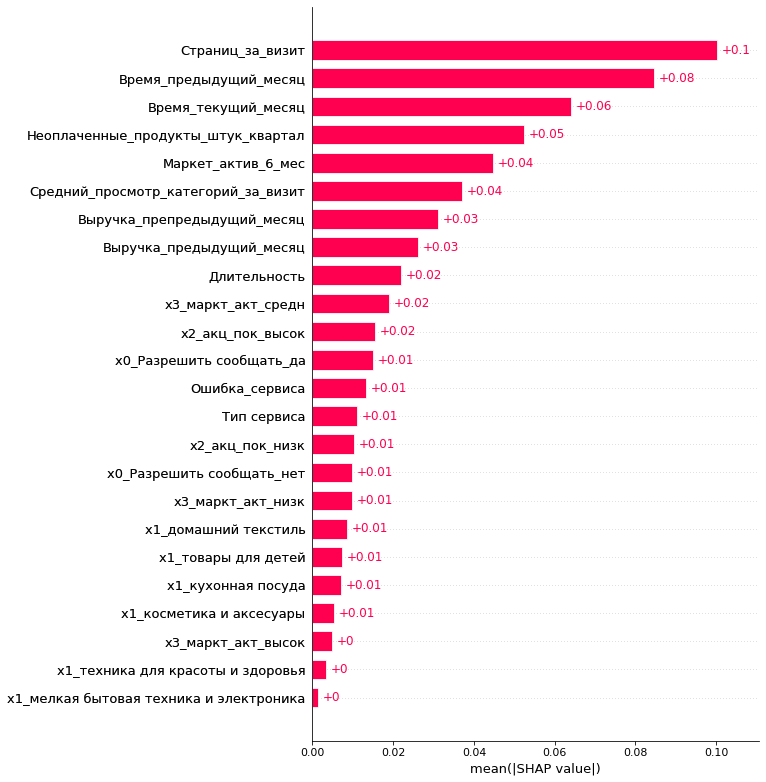

In [104]:
#Ура!!!
#!pip install -Uq matplotlib

shap.plots.bar(shap_values, max_display=30)

## Сегментация покупателей

In [105]:
data_full_X = data_full.drop('Покупательская активность', axis=1)
data_full_Y = data_full['Покупательская активность']

pred = grid.best_estimator_.predict(data_full_X)
proba = grid.best_estimator_.predict_proba(data_full_X)

total = pd.concat([data_full_X, data_full_Y],axis = 1)
total['прогноз'] = pred.tolist()
total['вероятность'] = proba[:,1].tolist()

total['прогноз'] = total['прогноз'].apply(lambda x : 'Снизится' if x==1 else 'Сохранится')
total = total.merge(money, on='id')
total.head()

id Тип сервиса      Разрешить сообщать  Маркет_актив_6_мес  \
0  215349     премиум   Разрешить сообщать_да                 4.4   
1  215350    стандарт  Разрешить сообщать_нет                 4.9   
2  215351    стандарт   Разрешить сообщать_да                 3.2   
3  215352    стандарт  Разрешить сообщать_нет                 5.1   
4  215353    стандарт   Разрешить сообщать_да                 3.3   

  Маркет_актив_тек_мес  Длительность Акционные_покупки Популярная_категория  \
0      маркт_акт_средн           819     акц_пок_высок     товары для детей   
1       маркт_акт_низк           539      акц_пок_низк    домашний текстиль   
2      маркт_акт_высок           896     акц_пок_высок     товары для детей   
3       маркт_акт_низк          1064     акц_пок_высок     товары для детей   
4      маркт_акт_средн           762      акц_пок_низк    домашний текстиль   

   Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
0                                    4                                   4   
1                                    5                                   2   
2                                    5                                   0   
3                                    3                                   2   
4                                    4                                   1   

   Ошибка_сервиса  Страниц_за_визит  Выручка_предыдущий_месяц  \
0               2                 5                    5216.0   
1               1                 5                    5457.5   
2               6                 4                    6158.0   
3               3                 2                    5807.5   
4               1                 4                    4738.5   

   Выручка_препредыдущий_месяц  Время_предыдущий_месяц  Время_текущий_месяц  \
0                       4472.0                      12                   10   
1                       4826.0                       8                   13   
2                       4793.0                      11                   13   
3                       4594.0                       8                   11   
4                       5124.0                      10                   10   

  Покупательская активность     прогноз  вероятность  Прибыль  
0                 снизилась    Снизится     0.658969     4.16  
1                 снизилась  Сохранится     0.552621     3.13  
2                 снизилась  Сохранится     0.597494     4.87  
3                 снизилась    Снизится     0.956922     4.21  
4                 снизилась    Снизится     0.775097     3.95

In [106]:
total[['вероятность', 'Прибыль']].describe()

вероятность      Прибыль
count  1297.000000  1297.000000
mean      0.383368     3.997610
std       0.391549     1.010813
min       0.008521     0.860000
25%       0.094083     3.300000
50%       0.122653     4.040000
75%       0.944101     4.670000
max       1.000000     7.430000

<Axes: xlabel='вероятность', ylabel='Прибыль'>

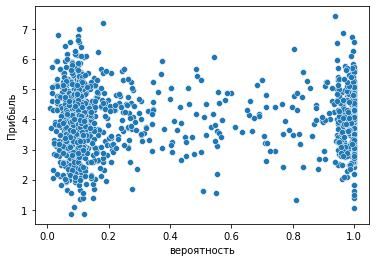

In [107]:
sns.scatterplot(data=total, x="вероятность", y="Прибыль")

<div class="alert alert-info"> Для того, чтобы что-то предлагать Клиентам, они должны дать нам разрешение на это. Поэтому целевой сегмент - это Клиенты с Разрешением = да <div>

In [108]:
segment = total[(total['Разрешить сообщать']=='Разрешить сообщать_да')].drop('Разрешить сообщать', axis = 1)
segment.head()

id Тип сервиса  Маркет_актив_6_мес Маркет_актив_тек_мес  Длительность  \
0  215349     премиум                 4.4      маркт_акт_средн           819   
2  215351    стандарт                 3.2      маркт_акт_высок           896   
4  215353    стандарт                 3.3      маркт_акт_средн           762   
5  215354    стандарт                 5.1       маркт_акт_низк           431   
7  215356    стандарт                 4.2      маркт_акт_средн           192   

  Акционные_покупки   Популярная_категория  \
0     акц_пок_высок       товары для детей   
2     акц_пок_высок       товары для детей   
4      акц_пок_низк      домашний текстиль   
5      акц_пок_низк  косметика и аксесуары   
7      акц_пок_низк  косметика и аксесуары   

   Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
0                                    4                                   4   
2                                    5                                   0   
4                                    4                                   1   
5                                    2                                   3   
7                                    2                                   2   

   Ошибка_сервиса  Страниц_за_визит  Выручка_предыдущий_месяц  \
0               2                 5                    5216.0   
2               6                 4                    6158.0   
4               1                 4                    4738.5   
5               7                 2                    5685.0   
7               1                 3                    4146.5   

   Выручка_препредыдущий_месяц  Время_предыдущий_месяц  Время_текущий_месяц  \
0                       4472.0                      12                   10   
2                       4793.0                      11                   13   
4                       5124.0                      10                   10   
5                       4503.0                      11                   12   
7                       4433.0                       6                    7   

  Покупательская активность     прогноз  вероятность  Прибыль  
0                 снизилась    Снизится     0.658969     4.16  
2                 снизилась  Сохранится     0.597494     4.87  
4                 снизилась    Снизится     0.775097     3.95  
5                 снизилась    Снизится     0.667337     3.62  
7                 снизилась    Снизится     1.000000     4.93

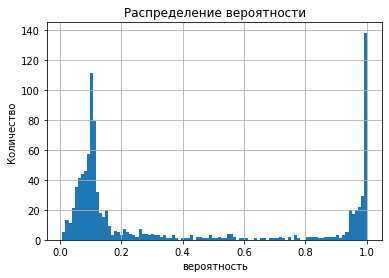

In [109]:
segment['вероятность'].hist(bins=100)
plt.title('Распределение вероятности')
plt.xlabel('вероятность')
plt.ylabel('Количество')
plt.show()

<div class="alert alert-info"> Далее - наш целевой сегмент - Клиенты, у которых высокая вероятность снижения активности
    К таковым, судя по графику распределения можно отнести Клиентов с вероятностью >=0,8<div>

In [110]:
segment = segment[(segment['вероятность']>=0.8)].drop('вероятность', axis = 1)
segment.head()

id Тип сервиса  Маркет_актив_6_мес Маркет_актив_тек_мес  Длительность  \
7   215356    стандарт                 4.2      маркт_акт_средн           192   
9   215360     премиум                 3.9       маркт_акт_низк           623   
10  215361    стандарт                 5.1      маркт_акт_средн           199   
13  215364     премиум                 4.3      маркт_акт_средн           708   
14  215365    стандарт                 3.9      маркт_акт_средн           167   

   Акционные_покупки            Популярная_категория  \
7       акц_пок_низк           косметика и аксесуары   
9       акц_пок_низк                 кухонная посуда   
10      акц_пок_низк  техника для красоты и здоровья   
13     акц_пок_высок               домашний текстиль   
14     акц_пок_высок  техника для красоты и здоровья   

    Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
7                                     2                                   2   
9                                     3                                   1   
10                                    4                                   5   
13                                    3                                   3   
14                                    6                                   4   

    Ошибка_сервиса  Страниц_за_визит  Выручка_предыдущий_месяц  \
7                1                 3                    4146.5   
9                4                 7                    5304.5   
10               2                 3                    6400.0   
13               3                 3                    5795.5   
14               2                 5                    4577.0   

    Выручка_препредыдущий_месяц  Время_предыдущий_месяц  Время_текущий_месяц  \
7                        4433.0                       6                    7   
9                        5555.0                       9                    6   
10                       4597.0                      11                   13   
13                       4942.0                      11                    9   
14                       4190.0                       6                   10   

   Покупательская активность   прогноз  Прибыль  
7                  снизилась  Снизится     4.93  
9                  снизилась  Снизится     4.55  
10                 снизилась  Снизится     4.03  
13                 снизилась  Снизится     2.67  
14                 снизилась  Снизится     3.65

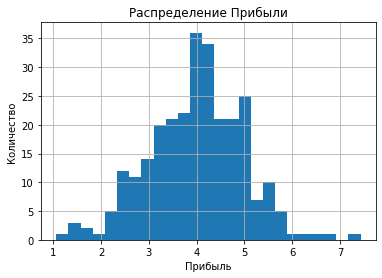

In [111]:
segment['Прибыль'].hist(bins=25)
plt.title('Распределение Прибыли')
plt.xlabel('Прибыль')
plt.ylabel('Количество')
plt.show()

<div class="alert alert-info"> Далее - наш целевой сегмент - Клиенты, у которых высокая прибыльность
    К таковым, судя по графику распределения можно отнести Клиентов с прибылью >=4 - выше среднего<div>

Итак, наш целевой сегмент:
- клиенты, которые дали разрешения на предложения
- клиенты, для которых вероятность снижения интереса, согласно нашей мсодели >=0,8
- клиенты, для которых прибыль > 4 - выше среднего

In [112]:
segment = segment[(segment['Прибыль']>4)].drop('Прибыль', axis = 1)
segment

id Тип сервиса  Маркет_актив_6_мес Маркет_актив_тек_мес  \
7     215356    стандарт                 4.2      маркт_акт_средн   
9     215360     премиум                 3.9       маркт_акт_низк   
10    215361    стандарт                 5.1      маркт_акт_средн   
17    215368     премиум                 3.8      маркт_акт_высок   
24    215375     премиум                 3.0      маркт_акт_средн   
...      ...         ...                 ...                  ...   
551   215902    стандарт                 3.3       маркт_акт_низк   
578   215929     премиум                 4.0      маркт_акт_средн   
582   215933    стандарт                 4.6      маркт_акт_средн   
1213  216564    стандарт                 5.6      маркт_акт_средн   
1285  216636     премиум                 2.4      маркт_акт_средн   

      Длительность Акционные_покупки            Популярная_категория  \
7              192      акц_пок_низк           косметика и аксесуары   
9              623      акц_пок_низк                 кухонная посуда   
10             199      акц_пок_низк  техника для красоты и здоровья   
17             829      акц_пок_низк  техника для красоты и здоровья   
24             558     акц_пок_высок                товары для детей   
...            ...               ...                             ...   
551            871      акц_пок_низк  техника для красоты и здоровья   
578            599      акц_пок_низк                товары для детей   
582            316     акц_пок_высок           косметика и аксесуары   
1213           342     акц_пок_высок                 кухонная посуда   
1285           996      акц_пок_низк                 кухонная посуда   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
7                                       2                                   2   
9                                       3                                   1   
10                                      4                                   5   
17                                      2                                   2   
24                                      3                                   3   
...                                   ...                                 ...   
551                                     2                                   4   
578                                     2                                   8   
582                                     2                                   5   
1213                                    2                                   7   
1285                                    3                                   4   

      Ошибка_сервиса  Страниц_за_визит  Выручка_предыдущий_месяц  \
7                  1                 3                    4146.5   
9                  4                 7                    5304.5   
10                 2                 3                    6400.0   
17                 6                 1                    5823.0   
24                 7                 4                    5253.5   
...              ...               ...                       ...   
551                2                17                    5439.0   
578                4                 7                    5481.0   
582                6                13                    6102.0   
1213               5                 8                    4930.0   
1285               5                 6                    5644.5   

      Выручка_препредыдущий_месяц  Время_предыдущий_месяц  \
7                          4433.0                       6   
9                          5555.0                       9   
10                         4597.0                      11   
17                         4536.0                      11   
24                         4715.0                       8   
...                           ...                     ...   
551                        4818.0                      17   
578                        4983.0     

Рассмотрим целевой сегмент по 4 направлениям:
- коммуникация с клиентом
- продуктовое поведение
- поведение на сайте
- финансовое поведение

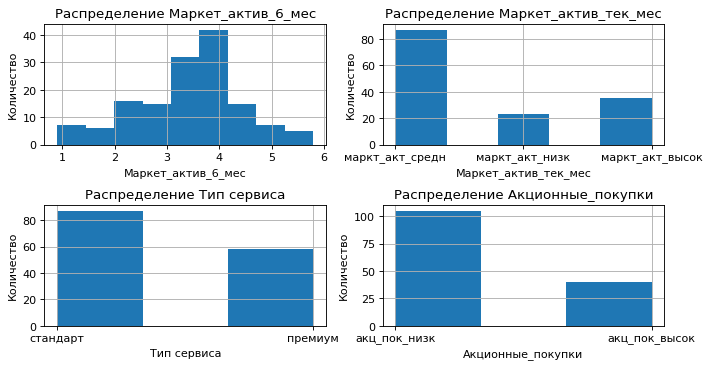

In [113]:
figure(figsize=(10, 5), dpi=80)
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

plt.subplot(2, 2, 1)
segment['Маркет_актив_6_мес'].hist(bins=9)
plt.title('Распределение Маркет_актив_6_мес')
plt.xlabel('Маркет_актив_6_мес')
plt.ylabel('Количество')

plt.subplot(2, 2, 2)
segment['Маркет_актив_тек_мес'].hist(bins=5)
plt.title('Распределение Маркет_актив_тек_мес')
plt.xlabel('Маркет_актив_тек_мес')
plt.ylabel('Количество')

plt.subplot(2, 2, 3)
segment['Тип сервиса'].hist(bins=3)
plt.title('Распределение Тип сервиса')
plt.xlabel('Тип сервиса')
plt.ylabel('Количество')

plt.subplot(2, 2, 4)
segment['Акционные_покупки'].hist(bins=3)
plt.title('Распределение Акционные_покупки')
plt.xlabel('Акционные_покупки')
plt.ylabel('Количество')

plt.show()

С точки зрения коммуникаций с Клиентом (теряющих интерес)
- большинство имеет среднюю маркетинговую активность, однако, есть и такие, которые имеют низкую маркетинговую активность. Причем, ориентроваться будем на активность за 6 месяцев, т.к. именно этот фактор входит в топ-5 по влиянию. Учитывая этот факт целесообразно таковым клиентам (маркетинговой активностями ниже 4) направить больше рекламной продукции


In [114]:
market_flow = segment.loc[segment['Маркет_актив_6_мес']<4,'id'].tolist()
market_flow.sort()
len(market_flow)

93

- часть клиентов активно используют акционные покупки - значит, заинтересованы в цене. Таким клиентам (с высокими акционными покупками) можно направить скидочные купоны на наибоее интересующие их товары (по популярной категории)
(и соответственно убрать их из списка тех, кому мы определили больше направлять рекламной продукции)

In [115]:
price_flow = segment.loc[segment['Акционные_покупки']=='акц_пок_высок','id'].tolist()#.sort()
market_flow = list(set(market_flow)-set(price_flow))#.sort()
market_flow.sort()
#print('купоны', (price_flow))
#print('ост маркет активность', (market_flow))

In [116]:
print('купоны', len(price_flow))
print('ост маркет активность', len(market_flow))

купоны 40
ост маркет активность 71


In [117]:
segment[segment['Акционные_покупки']=='акц_пок_высок'].groupby('Популярная_категория')['id'].count()

Популярная_категория
домашний текстиль                        6
косметика и аксесуары                    8
кухонная посуда                          4
мелкая бытовая техника и электроника     2
техника для красоты и здоровья           4
товары для детей                        16
Name: id, dtype: int64

- часть клиентов имеют стандартную подписку, и таковым есть смысл предложить переход на премиум (со скидкой или с бесплатным пробным периодом)

In [118]:
subscribe_flow = segment.loc[segment['Тип сервиса']=='стандарт','id'].tolist()
market_flow = list(set(market_flow)-set(subscribe_flow))#.sort()
subscribe_flow = list(set(subscribe_flow)-set(price_flow))
print('upgrade подписка', len(subscribe_flow))
print('ост маркет активность', len(market_flow))

upgrade подписка 60
ост маркет активность 33


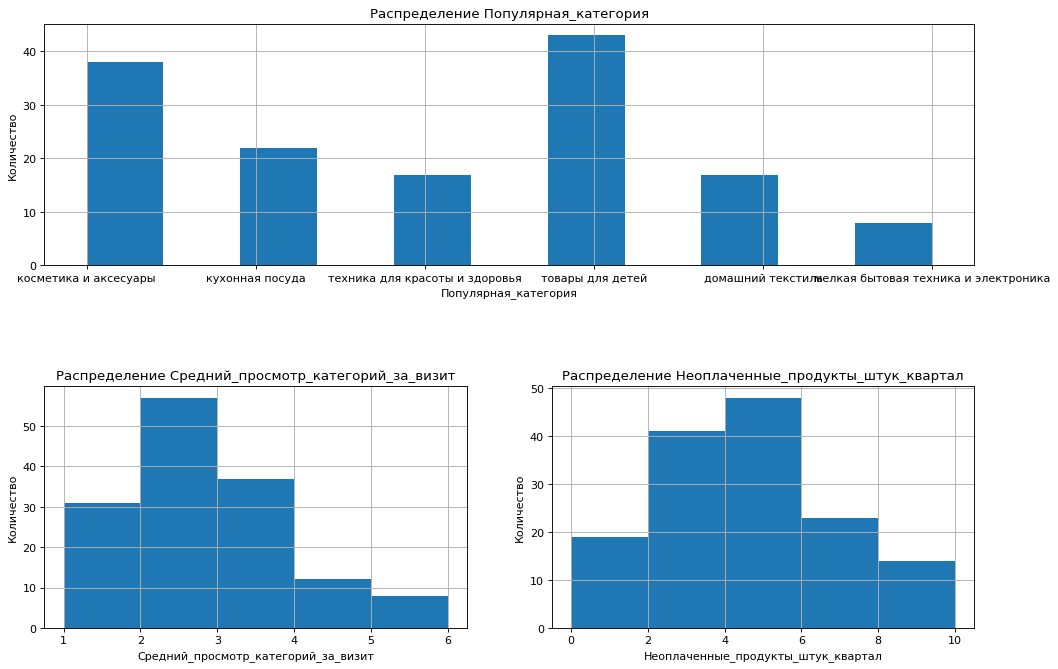

In [119]:
figure(figsize=(15, 10), dpi=80)
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

plt.subplot(2, 1, 1)
segment['Популярная_категория'].hist(bins=11)
plt.title('Распределение Популярная_категория')
plt.xlabel('Популярная_категория')
plt.ylabel('Количество')

plt.subplot(2, 2, 3)
segment['Средний_просмотр_категорий_за_визит'].hist(bins=5)
plt.title('Распределение Средний_просмотр_категорий_за_визит')
plt.xlabel('Средний_просмотр_категорий_за_визит')
plt.ylabel('Количество')

plt.subplot(2, 2, 4)
segment['Неоплаченные_продукты_штук_квартал'].hist(bins=5)
plt.title('Распределение Неоплаченные_продукты_штук_квартал')
plt.xlabel('Неоплаченные_продукты_штук_квартал')
plt.ylabel('Количество')

plt.show()

С точки зрения продуктового поведения:
- большинство клиентов приходится на категорию товаров для детей - вероятно, магазин не располдагает достаточным ассортиментом, и нужно увелимчивать позиции в данной категории, либо цены высоки, и тогда таким клиентам необходимо дать скдку на товары интересующих их категорий
- большинство клиентов имеет целенаправленное посещение, и скорее всего простамтривают именно интересующую их категорию. Возможно стоит таким клиентам при посещении показывать всплывающие окна с наиболее интересными предложениями из других категорий

In [120]:
directcoupon_flow = segment.loc[segment['Популярная_категория']=='товары для детей','id'].tolist()
directcoupon_flow = list(set(directcoupon_flow)-set(price_flow)- set(subscribe_flow))#.sort()
market_flow = list(set(market_flow)-set(directcoupon_flow))#.sort()
print('купон на товары детям', len(directcoupon_flow))
print('ост маркет активность', len(market_flow))

купон на товары детям 6
ост маркет активность 31


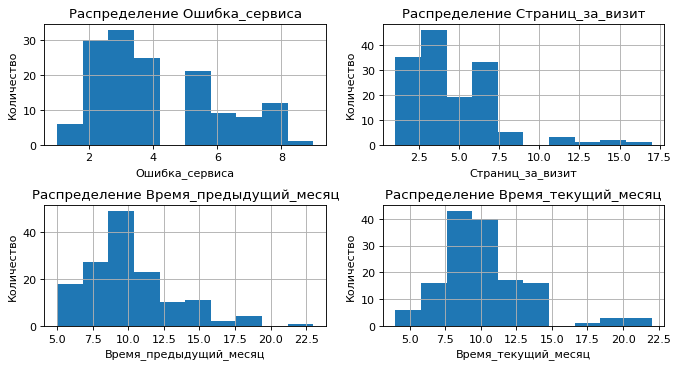

In [121]:
figure(figsize=(10, 5), dpi=80)
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

plt.subplot(2, 2, 1)
segment['Ошибка_сервиса'].hist(bins=10)
plt.title('Распределение Ошибка_сервиса')
plt.xlabel('Ошибка_сервиса')
plt.ylabel('Количество')

plt.subplot(2, 2, 2)
segment['Страниц_за_визит'].hist(bins=10)
plt.title('Распределение Страниц_за_визит')
plt.xlabel('Страниц_за_визит')
plt.ylabel('Количество')

plt.subplot(2, 2, 3)
segment['Время_предыдущий_месяц'].hist(bins=10)
plt.title('Распределение Время_предыдущий_месяц')
plt.xlabel('Время_предыдущий_месяц')
plt.ylabel('Количество')

plt.subplot(2, 2, 4)
segment['Время_текущий_месяц'].hist(bins=10)
plt.title('Распределение Время_текущий_месяц')
plt.xlabel('Время_текущий_месяц')
plt.ylabel('Количество')

plt.show()

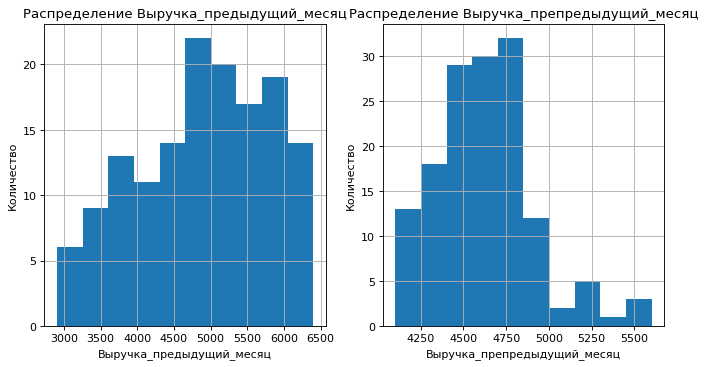

In [122]:
figure(figsize=(10, 5), dpi=80)
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

plt.subplot(1, 2, 1)
segment['Выручка_предыдущий_месяц'].hist(bins=10)
plt.title('Распределение Выручка_предыдущий_месяц')
plt.xlabel('Выручка_предыдущий_месяц')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
segment['Выручка_препредыдущий_месяц'].hist(bins=10)
plt.title('Распределение Выручка_препредыдущий_месяц')
plt.xlabel('Выручка_препредыдущий_месяц')
plt.ylabel('Количество')

plt.show()

С точки зрения поведения на сайте и финансового поведения особых предложений не созрело

Таким образом, мы выделили сегмент, ограниченный условиями:
- имеется разрешение на рассылку
- прибыль выше 4
- вероятность потери интереса выше 0,8

В данном сегменте образовалось 145 клиентов, к каждому из которых нужен индивидуальный подход.

Для сохранения инетереса работы с сайтом предлагается:
- 40 клиентам направить купоны на скидку в их предпочитаемом разделе товаров:
домашний текстиль                        6
косметика и аксесуары                    8
кухонная посуда                          4
мелкая бытовая техника и электроника     2
техника для красоты и здоровья           4
товары для детей                        16

- 60 клиентов имеют стандартную пордписку, таковым можно предложить премиум подписку с бесплатным периодом на 3 месяца
- 6 клиентов (которые не попадают ни под одну из активностей, описанных выше) являются потребителями самой популярной категории (Товары для детей) - им также дополнительно можно направить купоны на скидку для этой категории
- наконец, 31 клиент имел низкое маркетинговое взаимодействие - как вариант с этим контингетом ожно просто увеличитоь маркетинговое взаимодествие


## Выводы

Данные состоят из 4 таблиц: 
- данные о поведении на сайте
- данные с выручкой
- данные о времени на сайте
- данные о среднемесячной прибыли

На превом этапе была осуществлена предобработка данных:
- были проверены пропуски в таблицах и таковых обнаружено не было
- также не было обнаружено несочетающихся типов данных с содержанием столбцов
- в данных были удалены спецсимволы, а также категориальные столбца были приведены к нижнему регистру
- были обнаружены операционные ошибки в столбцах Тип сервиса и Периоде

На втором этапе был проведен статистический анализ данных:
- были выявлены что ни один из непрерывных столбцов не носит нормальный характер
- ряд непрерывных столбцов носит категориальный характер (Распределение покупок по акции и Маркет_актив_тек_мес)
- обнаружен один выброс по Выручке по одному Клиенту. Это значение было заменено на Выручку в предыдущем периоде
- для дальнейшей корректной работе при построении модели необходимо было удалить пропуски в выручке - так, чтобы по каждому Клиенту была история за три месяца

По результатам предваорительного анализа было определено:
- Сильная зависимость прослеживается между факторами: Выручка за тек месяц и Выручка за предыдущий месяц = 0,84 (> 0,75). 
Учитывая, что выручка за предыдущий месяц имеет большую корреляцию с целевым признаком (0,23 vs 0,20) - была удалена признак Выручка за текущий месяц
- был построен Pipeline с моделями  KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression и  SVC

Отбор модели:
- среди всех построенных моделей лучшей оказалась SVC(degree=4, kernel='poly', probability=True, random_state=42), StandardScaler()
- Метрика лучшей модели на тренировочной выборке: 0.9082761621125257
- Метрика ROC-AUC на тестовой выборке: 0.8368239447921683
- Площадь ROC-кривой: 0.9063151982025357
- Наиболее важные признкаки модели:
	- Страниц_за_визит
	- Время в предыдущем месяце
	- Время в текущем месяце
	- Маркетинговая активность 
	Высокие значения каждого из этих параметров ведет к тому, что модель присвоит уцелевой переменной признак 0

	-Неоплаченные продукты 
	Высокие значения этого параметра ведет к тому, что модель присвоит уцелевой переменной признак 1

Интерпретировать можно следующим образом: Чем больше активности проявляет клиент (посещает количество страниц, проводит времени в настоящем и прошлом месяцах (то есть он сохраняет активность на протяжении двух месяцев), участвует в маркетинговых акциях) - тем с большей вероятностью он продолжит это делат ьи в дальнейшем, то есть активность его не снизится
Однако, если Клиент имеет неоплаченные заказы - это сигнал к тому, что в последующем его активность упаде- 

Сегментация:
- имеется разрешение на рассылку
- прибыль выше 4
- вероятность потери интереса выше 0,8

В данном сегменте образовалось 145 клиентов, к каждому из которых нужен индивидуальный подход.

Для сохранения инетереса работы с сайтом предлагается:
- 40 клиентам направить купоны на скидку в их предпочитаемом разделе товаров:
домашний текстиль                        6
косметика и аксесуары                    8
кухонная посуда                          4
мелкая бытовая техника и электроника     2
техника для красоты и здоровья           4
товары для детей                        16

- 60 клиентов имеют стандартную пордписку, таковым можно предложить премиум подписку с бесплатным периодом на 3 месяца
- 6 клиентов (которые не попадают ни под одну из активностей, описанных выше) являются потребителями самой популярной категории (Товары для детей) - им также дополнительно можно направить купоны на скидку для этой категории
- наконец, 31 клиент имел низкое маркетинговое взаимодействие - как вариант с этим контингетом ожно просто увеличитоь маркетинговое взаимодествие
